# Heatmap
Heatmap of terms over time for Euroleaks and Communiques.

In [42]:
import re
import time
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

## stopwords and collocations

In [43]:
# stopwords
with open('../data/euroleaks/stopwords.json', 'r') as f:
    stopwords = json.load(f)
    
# collocations
def apply_trigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2,b3 in set_colloc:
        res = res.replace(f'{b1} {b2} {b3}', f'{b1}_{b2}_{b3}')
    return res

def apply_bigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2 in set_colloc:
        res = res.replace(f'{b1} {b2}', f'{b1}_{b2}')
    return res

with open('../data/collocations/trigrams.json', 'r') as f:
    trigram_colloc = json.load(f)

with open('../data/collocations/bigrams.json', 'r') as f:
    bigram_colloc = json.load(f)

In [44]:
stopwords.keys()

dict_keys(['names', 'disfluency', 'courtesy'])

In [45]:
nlp = spacy.load("en_core_web_sm", exclude=["ner"])

## helper functions

In [46]:
def filter_token(token):
    return token.pos_ in {'ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB'}\
        and not token.lemma_.lower() in nlp.Defaults.stop_words\
        and not token.lower_ in stopwords['names']\
        and not token.lower_ in stopwords['disfluency']\
        and not token.lemma_.lower() in stopwords['courtesy']\
        and len(token.lemma_) > 1

In [47]:
def find_most_prominent_k_words(k, X, vectorizer):
    
    print(f'matrix shape: {X.shape}\n')
    
    tfidf = X.sum(axis =0).A1
    sort_ix = np.argsort(tfidf)[::-1]
    most_prominent_words = np.array(vectorizer.get_feature_names())[sort_ix][:k]
    
    max_length = pd.Series(most_prominent_words).apply(lambda s: len(s)).max()
    
    for word, score in zip(most_prominent_words, tfidf[sort_ix][:k]):
        print(f'{word}{" "*(max_length-len(word))}\t|\t{round(score,3)}')
        
    return most_prominent_words

def find_most_prominent_words_cutoff(cut_off, X, vectorizer, verbose=False):
    
    print(f'matrix shape: {X.shape}\n')
    
    tfidf = X.sum(axis =0).A1
    sort_ix = np.argsort(tfidf)[::-1]
    mask = tfidf[sort_ix] > cut_off
    most_prominent_words = np.array(vectorizer.get_feature_names())[sort_ix][mask]
    
    print(f'number of prominent words: {len(most_prominent_words)}\n')
    print(f'ratio of prominent words (relative to vocabulary size): {round(float(len(most_prominent_words)) / len(vectorizer.get_feature_names()) * 100,2)} %\n')
    
    if verbose:
        max_length = pd.Series(most_prominent_words).apply(lambda s: len(s)).max()
        for word, score in zip(most_prominent_words, tfidf[sort_ix][mask]):
            print(f'{word}{" "*(max_length-len(word))}\t|\t{round(score,3)}')
        
    return most_prominent_words

## Communiques

In [48]:
communiques = pd.read_csv('../data/communiques/cleaned.csv')

# group by date
communiques_groupby_date = communiques.drop(columns=['title']).groupby('date').apply(lambda s: ' '.join(s.story))

# preprocess
communique_documents = [
    ' '.join([token.lemma_ .lower() for sentence in nlp(doc).sents for token in sentence
            if filter_token(token)
    ])
    for doc in communiques_groupby_date.values
]

# leave out empty documents
communique_documents = [d for d in communique_documents if len(d)>1]

# apply collocations
communique_documents = [
    apply_bigram_colloc(apply_trigram_colloc(doc, trigram_colloc), bigram_colloc)
    for doc in communique_documents]

# get labels
communique_dates = communiques_groupby_date.index.to_series().apply(lambda s: pd.to_datetime(s).strftime('%d/%m'))

# tfidf
communique_vectorizer = TfidfVectorizer(analyzer='word',
                                   min_df=1, # word has to be in at least two documents
                                   max_df=0.95, # word has to be in less the 95% of documents
                                   smooth_idf=True, # Smooth idf weights by adding one to document frequencies, as if an extra document was seen containing every term in the collection exactly once. Prevents zero divisions.
                                   sublinear_tf=False) # replace tf with 1 + log(tf).

communique_X = communique_vectorizer.fit_transform(communique_documents)

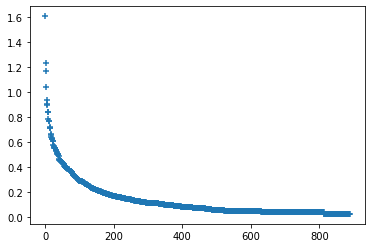

In [49]:
communique_tfidf = communique_X.sum(axis =0).A1

plt.scatter(range(len(communique_tfidf)), np.sort(communique_tfidf)[::-1], marker='+')

In [50]:
communique_cutoff = 0.2

communique_most_prominent_words = find_most_prominent_words_cutoff(communique_cutoff, communique_X, communique_vectorizer)

matrix shape: (13, 890)

number of prominent words: 167

ratio of prominent words (relative to vocabulary size): 18.76 %



In [51]:
_ = find_most_prominent_k_words(30, communique_X, communique_vectorizer)

matrix shape: (13, 890)

institution    	|	1.607
proposal       	|	1.232
greek_authority	|	1.171
program        	|	1.045
talk           	|	0.94
measure        	|	0.909
greece         	|	0.899
agreement      	|	0.841
work           	|	0.838
current        	|	0.788
inform         	|	0.769
greek          	|	0.769
situation      	|	0.722
agree          	|	0.714
reform         	|	0.712
discuss        	|	0.664
today          	|	0.659
far            	|	0.642
state_play     	|	0.635
extension      	|	0.629
arrangement    	|	0.628
meeting        	|	0.608
discussion     	|	0.607
start          	|	0.574
view           	|	0.571
commitment     	|	0.562
euro_area      	|	0.558
financial      	|	0.555
referendum     	|	0.555
progress       	|	0.552


In [52]:
print(f'Terms that are present in more than {int(len(communique_documents) * 0.95)} documents are disregarded.')

Terms that are present in more than 12 documents are disregarded.


In [53]:
print(f'Communiques vocabulary size: {len(communique_vectorizer.get_feature_names())}')
print(f'Number of documents: {len(communique_documents)}')

Communiques vocabulary size: 890
Number of documents: 13


## Euroleaks

In [54]:
leaks = pd.read_csv('../data/euroleaks/squeezed.csv')

# group by date
leaks_groupby_date = leaks.drop(columns=['speaker']).groupby('date').apply(lambda s: ' '.join(s.speech))

# preprocess
leaks_documents = [
    ' '.join([token.lemma_.lower() for sentence in nlp(doc).sents for token in sentence
            if filter_token(token)
    ])
    for doc in leaks_groupby_date.values 
]

# leave out empty documents
leaks_documents = [d for d in leaks_documents if len(d)>1]

# apply collocations
leaks_documents = [
    apply_bigram_colloc(apply_trigram_colloc(doc, trigram_colloc), bigram_colloc)
    for doc in leaks_documents]

# get labels
leaks_dates = leaks_groupby_date.index.to_series().apply(lambda s: pd.to_datetime(s).strftime('%d/%m'))

# tfidf
leaks_vectorizer = TfidfVectorizer(analyzer='word',
                                   min_df=1, # word has to be in at least two documents
                                   max_df=0.95, # word has to be in less the 95% of documents
                                   smooth_idf=True, # Smooth idf weights by adding one to document frequencies, as if an extra document was seen containing every term in the collection exactly once. Prevents zero divisions.
                                   sublinear_tf=False) # replace tf with 1 + log(tf).

leaks_X = leaks_vectorizer.fit_transform(leaks_documents)

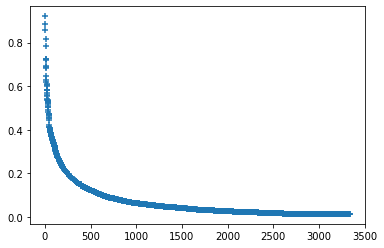

In [55]:
leaks_tfidf = leaks_X.sum(axis =0).A1

plt.scatter(range(len(leaks_tfidf))[5:], np.sort(leaks_tfidf)[::-1][5:], marker='+')

In [56]:
leaks_cutoff = 0.15

leaks_most_prominent_words = find_most_prominent_words_cutoff(leaks_cutoff, leaks_X, leaks_vectorizer)

matrix shape: (12, 3336)

number of prominent words: 389

ratio of prominent words (relative to vocabulary size): 11.66 %



In [57]:
_ = find_most_prominent_k_words(30, leaks_X, leaks_vectorizer)

matrix shape: (12, 3336)

agreement   	|	1.913
program     	|	1.376
process     	|	1.175
reform      	|	1.131
referendum  	|	1.013
letter      	|	0.921
eurogroup   	|	0.887
list        	|	0.86
new         	|	0.814
like        	|	0.784
change      	|	0.727
liquidity   	|	0.727
pension     	|	0.721
month       	|	0.693
week        	|	0.689
day         	|	0.685
document    	|	0.645
progress    	|	0.629
fiscal      	|	0.618
tomorrow    	|	0.61
political   	|	0.604
prior_action	|	0.603
use         	|	0.584
parliament  	|	0.583
policy      	|	0.581
review      	|	0.57
statement   	|	0.558
table       	|	0.553
believe     	|	0.54
problem     	|	0.538


In [58]:
print(f'Terms that are presint in more than {int(len(leaks_documents) * 0.95)} documents are disregarded.')

Terms that are presint in more than 11 documents are disregarded.


In [59]:
print(f'Communiques vocabulary size: {len(leaks_vectorizer.get_feature_names())}')
print(f'Number of documents: {len(leaks_documents)}')

Communiques vocabulary size: 3336
Number of documents: 12


## make figure for cutoffs

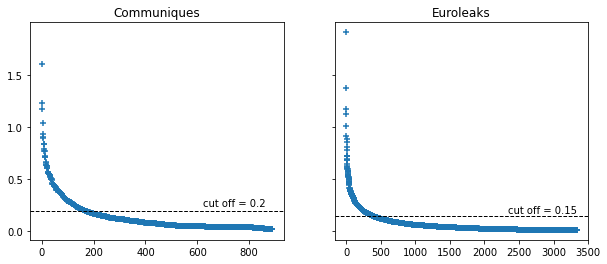

In [60]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10,4))

axes[0].scatter(range(len(communique_tfidf)), np.sort(communique_tfidf)[::-1], marker='+')
axes[0].axhline(communique_cutoff, 0,len(communique_tfidf), color='black', linewidth=1, linestyle='--')
axes[0].set_title('Communiques')
axes[0].set_yticks([0, .5, 1, 1.5])
axes[0].text(int(len(communique_tfidf)*.7), communique_cutoff*1.2, f'cut off = {communique_cutoff}')

axes[1].scatter(range(len(leaks_tfidf)), np.sort(leaks_tfidf)[::-1], marker='+')
axes[1].axhline(leaks_cutoff, 0,len(leaks_tfidf), color='black', linewidth=1, linestyle='--')
axes[1].set_title('Euroleaks')
axes[1].text(int(len(leaks_tfidf)*.7), leaks_cutoff*1.2, f'cut off = {leaks_cutoff}')

#fig.tight_layout()

fig.savefig('../figures/tfidf-cutoff.png')

## find differences

In [61]:
# prominent words in communiques which are not prominent in euroleaks
comm_but_not_leaks = []

for word in communique_most_prominent_words:
    if word not in leaks_most_prominent_words:
        comm_but_not_leaks.append(word)
        
print(f'Number of words: {len(comm_but_not_leaks)}\n')
for word in comm_but_not_leaks:
    print(word)

Number of words: 67

institution
proposal
greek_authority
talk
measure
greece
work
inform
greek
situation
agree
discuss
today
far
state_play
meeting
discussion
start
view
euro_area
financial
monday
time
come
good
greek_government
need
ground
issue
decision
recovery
look
pm
stock
government
basis
ireland
regular
thursday
efsf
number
end
portugal
step
note
cyprus
heads
initiative
inevitable
regrettable
short
tuesday
july
course
question
concerned
member_states
wide
main
press_conference
meantime
national_procedure
door
surveillance
intensive
spain
lot


In [62]:
# prominent words in communiques which are not prominent in euroleaks

leaks_but_not_comms = []

for word in leaks_most_prominent_words:
    if word not in communique_most_prominent_words:
        leaks_but_not_comms.append(word)
        
print(f'Number of words: {len(leaks_but_not_comms)}\n')
for word in leaks_but_not_comms:
    print(word)

Number of words: 289

letter
eurogroup
change
liquidity
pension
document
tomorrow
prior_action
parliament
believe
problem
public
greek_people
propose
debt
tax
second_letter
country
area
people
deal
athens
bank
line
mou
technical
significant
aide_memoire
set
market
meet
detail
rate
target
concern
package
answer
actually
low
authority
credibility
system
communication
esm
send
certainly
brussels_group
increase
find
sure
help
able
interest_rate
prime_minister
reason
high
general
tell
complete
fact
mandate
previous
ahead
push
ecb
large
great
growth_friendly
hope
respect
medium
intention
plan
speak
bill
matter
friday
exist
turn
sustainable
vote
paper
remark
gdp
additional
direction
moment
convergence
vat
amendment
require
create
early
morning
trust
run
difference
absolutely
action
credible
privatization
close
hour
euro_working_group
scenario
report
feel
available
happen
bit
expect
example
necessary
extremely
assess
perspective
implement
hand
sla
principle
money
effort
overall
approach
lead
s

In [63]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

assert len(intersection(comm_but_not_leaks, leaks_but_not_comms)) == 0

### words of interest (collect manually)

In [64]:
# manually collecter words of interest, which highlight differences

highlight_differences = set([
    
    # comms but not leaks
    #'institution', # prominent in both (vectorizere filters it out for leaks because present in every document)
    #'ireland',
    #'portugal',
    #'cyprus',
    'structural_reform',
    #'national_procedure',
    #'spain',
    'recovery',

    # leaks but not comms
    'letter',
    'liquidity',
    'pension',
    'parliament',
    'debt',
    'tax',
    'second_letter',
    'bank',
    'mou',
    'aide_memoire',
    'market',
    #'esm', # European stability mechanism
    'brussels_group',
    #'interest_rate',
    #'prime_minister',
    'mandate',
    #'ecb', # European Central Bank
    'bill',
    'gdp',
    'vat', # value-added tax
    'privatization',
    'sla', # staff level agreement
    #'low_interest_rate',
    'law',
    'primary_surplus',
    'labor_market',
    'recession',
    'budget',
    
    # interesting collocations
    'minimum_wage',
    'labor_market',
    'collective_bargaining',
    'structural_reform',
    'second_letter',
    #'non_performing_loan',
    #'capital_control',
    'primary_surplus',
    'aide_memoire',
    'brussels_group',
    #'quantitative_easing',
    'smp_bond',
    
    # prominent when tfidf trained on joint communiques + euroleaks
    'reform',
    'extension',
    'referendum',
    'list',
    'agreement',
    
    # domain knowledge (Varoufakis claims they refused to talk debt restructuring)
    'restructuring'
      
])

# convert to list so that ordering is fixed
highlight_differences = list(highlight_differences)
# sort the list
highlight_differences.sort()

In [65]:
print(len(highlight_differences))

34


### words that are completely absent from one vocabulary

In [66]:
from pprint import pprint

In [67]:
# words in communiques which are not prominent and are absent from euroleaks

my_list = [word for word in communique_vectorizer.get_feature_names() if word not in communique_most_prominent_words and word not in leaks_vectorizer.get_feature_names()]

print(len(my_list),'\n')
#pprint(my_list)

133 



In [68]:
# words in euroleaks which are not prominent and are absent from communiques

my_list = [word for word in leaks_vectorizer.get_feature_names() if word not in leaks_most_prominent_words and word not in communique_vectorizer.get_feature_names()]

print(len(my_list),'\n')
#pprint(my_list)

2500 



### inspect collocations

In [69]:
for word in set(communique_vectorizer.get_feature_names() + leaks_vectorizer.get_feature_names()):
    if '_' in word:
        print(word)

track_record
euro_working_group
half_percent
euro_area
central_banking
press_conference
successful_conclusion_review
arm_length
banking_union
financial_stability
safety_net
greek_government
mission_chief
debt_sustainability
collective_bargaining
prior_action
central_bank
govern_council
20th_february
smp_bond
technical_team
european_semester
greek_authority
duration_mffa
aide_memoire
growth_friendly
central_banks
prior_actions
united_states
debt_sustainability_analysis
product_market
common_ground
quantitative_easing
minimum_wage
international_monetary_fund
monetary_union
member_states
capital_control
sign_dotted_line
state_play
real_estate
member_state
labor_market
second_letter
interest_rate
anti_corruption
national_procedure
greek_governmental
conclusion_review
brussels_group
prime_minister
et_cetera
structural_reform
master_financial_assistance
successful_conclusion
greek_people
maximum_flexibility
central_banker
non_performing_loan
low_interest_rate
primary_surplus
uncharted_territ

## most prominent words (trained together)

In [70]:
documents = leaks_documents + communique_documents
dates = pd.concat((leaks_dates, communique_dates)).values

tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   min_df=1, # word has to be in at least two documents
                                   max_df=0.95, # word has to be in less the 95% of documents
                                   smooth_idf=True, # Smooth idf weights by adding one to document frequencies, as if an extra document was seen containing every term in the collection exactly once. Prevents zero divisions.
                                   sublinear_tf=False) # replace tf with 1 + log(tf).

X = tfidf_vectorizer.fit_transform(documents)

_ = find_most_prominent_k_words(30, X, tfidf_vectorizer)

matrix shape: (25, 3507)

institution	|	3.546
proposal   	|	2.359
agreement  	|	2.257
program    	|	2.118
need       	|	2.066
know       	|	1.933
work       	|	1.794
greece     	|	1.738
agree      	|	1.629
question   	|	1.595
measure    	|	1.591
reform     	|	1.578
greek      	|	1.522
come       	|	1.455
time       	|	1.393
government 	|	1.383
discussion 	|	1.382
referendum 	|	1.379
talk       	|	1.372
process    	|	1.36
situation  	|	1.328
meeting    	|	1.311
discuss    	|	1.24
list       	|	1.206
today      	|	1.188
new        	|	1.131
far        	|	1.119
issue      	|	1.109
current    	|	1.061
want       	|	1.033


In [74]:
# tfidf scores of words of interest, when tfidf is trained on joint text

from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(max_df=0.95)
counts = count_vectorizer.fit_transform(leaks_documents + communique_documents)

tfidf = X.sum(axis =0).A1

print()
print(f'word{" "*(20-4)}\t|\ttfidf\t|\tcount\t| relevant in\t| relevant in')
print(f'{" "*20}\t|\t\t|\t\t| communiques\t| euroleaks')
print('-'*90)
for word in highlight_differences:
    index = tfidf_vectorizer.vocabulary_[word]
    print(f'{word}{" "*(20-len(word))}\t|\t{round(tfidf[index],3)}\t|\t{counts.sum(axis=0).A1[count_vectorizer.vocabulary_[word]]}\t|\t{word in communique_most_prominent_words}\t|\t{word in leaks_most_prominent_words}')


word                	|	tfidf	|	count	| relevant in	| relevant in
                    	|		|		| communiques	| euroleaks
------------------------------------------------------------------------------------------
agreement           	|	2.257	|	299	|	True	|	True
aide_memoire        	|	0.344	|	31	|	False	|	True
bank                	|	0.514	|	63	|	False	|	True
bill                	|	0.241	|	13	|	False	|	True
brussels_group      	|	0.315	|	30	|	False	|	True
budget              	|	0.143	|	15	|	False	|	True
collective_bargaining	|	0.119	|	12	|	False	|	False
debt                	|	0.559	|	72	|	False	|	True
extension           	|	0.886	|	65	|	True	|	True
gdp                 	|	0.262	|	32	|	False	|	True
labor_market        	|	0.173	|	21	|	False	|	True
law                 	|	0.183	|	14	|	False	|	True
letter              	|	0.975	|	70	|	False	|	True
liquidity           	|	0.683	|	69	|	False	|	True
list                	|	1.206	|	126	|	True	|	True
mandate             	|	0.338	|	37	|	False	|	True
marke

## Figure
Grid: https://stackoverflow.com/questions/38973868/adjusting-gridlines-and-ticks-in-matplotlib-imshow

In [72]:
leaks_matshow = np.zeros((len(highlight_differences), len(leaks_dates)))

for i,word in enumerate(highlight_differences):
    if word in leaks_vectorizer.get_feature_names():
        leaks_matshow[i] = leaks_X.toarray()[:,leaks_vectorizer.get_feature_names().index(word)]
        
comm_matshow = np.zeros((len(highlight_differences), len(communique_dates)))

for i,word in enumerate(list(highlight_differences)):
    if word in communique_vectorizer.get_feature_names():
        comm_matshow[i,:] = communique_X.toarray()[:,communique_vectorizer.get_feature_names().index(word)]
    

<ipython-input-73-585dff3abe2a>:6: RuntimeWarning: divide by zero encountered in log
  axes[0].matshow(np.log(leaks_matshow), cmap='Blues')
<ipython-input-73-585dff3abe2a>:16: RuntimeWarning: divide by zero encountered in log
  axes[1].matshow(np.log(comm_matshow), cmap='Blues')


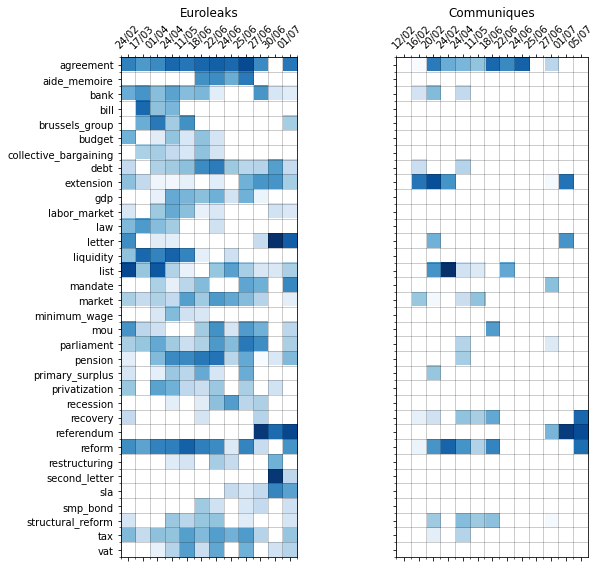

In [73]:
keywords = highlight_differences

fig, axes = plt.subplots(1,2,figsize=(10,8),sharey=True)

# leaks
axes[0].matshow(np.log(leaks_matshow), cmap='Blues')
axes[0].set_xticks(np.arange(len(leaks_dates)))
_ = axes[0].set_xticklabels(leaks_dates, rotation=45)
# grids
axes[0].set_xticks(np.arange(-.5, len(leaks_dates), 1), minor=True)
axes[0].set_yticks(np.arange(len(keywords)))
axes[0].set_yticks(np.arange(-.53, len(keywords), 1), minor=True)
axes[0].grid(which='minor', color='black', linestyle='-', linewidth=.5, alpha=.4)

# communiques
axes[1].matshow(np.log(comm_matshow), cmap='Blues')
axes[1].set_xticks(range(len(communique_dates)))
_ = axes[1].set_xticklabels(communique_dates, rotation=45)
# grids
axes[1].set_xticks(np.arange(-.53, len(leaks_dates), 1), minor=True)
axes[1].set_yticks(np.arange(len(keywords)))
axes[1].set_yticks(np.arange(-.53, len(keywords), 1), minor=True)
axes[1].grid(which='minor', color='black', linestyle='-', linewidth=.5, alpha=.4)

# shared y axis
axes[0].set_yticks(range(len(keywords)))
_ = axes[0].set_yticklabels(keywords)
#axes[1].set_yticks(range(len(keywords)))
#_ = axes[1].set_yticklabels(keywords)

axes[0].set_title('Euroleaks')
axes[1].set_title('Communiques')



fig.tight_layout()

fig.savefig('../figures/term_heatmap.png')

**TODO** investigate terms with text search and read into them:
- bank
- bill
- list

Note that I have taken the log of the matrix so that high scores don't dominate the color spectrum.

# Auxiliary text search

In [33]:
# count total number of occurences for each corpus

def count_occurences(word, corpus):
    
    from sklearn.feature_extraction.text import CountVectorizer

    count_vectorizer = CountVectorizer()

    counts = count_vectorizer.fit_transform(corpus)
    
    target_count = 0 if word not in count_vectorizer.get_feature_names() else counts.sum(axis=0).A1[count_vectorizer.vocabulary_[word]]
    
    print(f'Count for word "{word}" is: {target_count}')
    
    return target_count

In [34]:
count_occurences('pension', communique_documents)

Count for word "pension" is: 1


1

In [35]:
count_occurences('pension', leaks_documents)

Count for word "pension" is: 105


105

In [36]:
# leaks

def search_term(term):
    for i,row in leaks.iterrows():
        if term in row.speech.lower():
            date = pd.to_datetime(row.date).strftime('%d/%m')
            print(f'{row.speaker} ({date}):')
            print(row.speech)
            print()
            
#search_term('pension')

In [37]:
# communiques

def search_term(term):
    for i,row in communiques.iterrows():
        if term in row.story.lower():
            print(f'{row.title} ({row.date}):')
            print(row.story)
            print()
            
#search_term('pension')